In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from scipy.integrate import quad
from numpy.linalg import eig
import pandas as pd

In [2]:
data = {
    'Planet Name': ['TRAPPIST-1 b','TRAPPIST-1 c','TRAPPIST-1 d',
                    'TRAPPIST-1 e','TRAPPIST-1 f','TRAPPIST-1 g'
                    ,'TRAPPIST-1 h'] , 
     'Period(day)':  [1.510826,2.421937,4.049219,6.101013,9.207540,
                     12.352446,18.772866],
     'a (10^11 cm)' : [1.726,2.364,3.331,4.376,5.758,7.006, 9.529],
     'R (10^8 cm)' : [7.119,6.995,5.026,5.868,6.664,7.204,4.817] ,
     'M (10^27 g)' : [8.211,7.814,2.316,4.132,6.205,7.890,1.945],
     'mean_d (g cm^-3)' : [5.425,5.447,4.354,4.885,5.009,5.042,
                           4.147],
     'core_d (g cm^-3)' : [12.0,12.0,10.0,12.0,12.0,12.0,10.0]
    }
Table1 = pd.DataFrame(data=data)
Table1

,Planet Name,Period(day),a (10^11 cm),R (10^8 cm),M (10^27 g),mean_d (g cm^-3),core_d (g cm^-3)
0,TRAPPIST-1 b,1.510826,1.726,7.119,8.211,5.425,12.0
1,TRAPPIST-1 c,2.421937,2.364,6.995,7.814,5.447,12.0
2,TRAPPIST-1 d,4.049219,3.331,5.026,2.316,4.354,10.0
3,TRAPPIST-1 e,6.101013,4.376,5.868,4.132,4.885,12.0
4,TRAPPIST-1 f,9.207540,5.758,6.664,6.205,5.009,12.0
5,TRAPPIST-1 g,12.352446,7.006,7.204,7.890,5.042,12.0
6,TRAPPIST-1 h,18.772866,9.529,4.817,1.945,4.147,10.0


In [3]:
Table1['Planet Name'][0]

'TRAPPIST-1 b'

In [4]:
#Integratin functionality
def b_1(x):
    return (1/pi)*(np.cos(x)/(1 - 2*alpha*np.cos(x) + alpha**2
                             )**(3/2))
# ans_b1,err_b2=quad(b_1,0,2*pi)
def b_2(x):
    return (1/pi)*(np.cos(2*x)/(1 - 2*alpha*np.cos(x) + alpha**2
                             )**(3/2))

In [5]:
#--- Required information of Jupiter (1) and Saturn (2) --------
number_of_planets = 7
G = 6.67 * 10**-8 # cm^3 g^-1 s^-2
J2 = 0.0
J4 = 0.0
rad_sec = (180/pi) *(1/(3.17098*10**-8)) #deg/year

#Array of Inclination(I), increasing order of semi-major axis(a),
#mean motion in degree/year(n) and mass/mass_of_star(m_mc).
I = 0.1 #deg
m_sun = 1988500.0 #10^27 g (NASA)
m_star = 0.089 * m_sun
r_sun = 0.69570 #10^11 cm (NASA)
r_star = 0.117 * r_sun

a = Table1['a (10^11 cm)']
a = a.to_numpy()

M = Table1['M (10^27 g)'] 
M = M.to_numpy()

m_mc = M/m_star #unitless
m_mc = m_mc.astype(float)
gm = G*m_star #m^3 s^-2

inside_sqrt = (gm*(1+m_mc))/a**3
n = np.sqrt(inside_sqrt/10**6)*rad_sec #deg/year

In [6]:
#Matrices (B)

B = np.zeros((number_of_planets,number_of_planets))

for j in range(0,number_of_planets):
    sum_B = 0
    for k in range(0,number_of_planets):
        if k!=j:
            if k<j:
                alpha = a[k]/a[j] 
                alpha_bar = 1
            if k>j:
                alpha = a[j]/a[k]
                alpha_bar = alpha
            ans_b1,err_b1 = quad(b_1,0,2*pi)
            ans_b2,err_b2 = quad(b_2,0,2*pi)
            
            B[j,k] = n[j] * (1/4) * (m_mc[k]/(1 + m_mc[j])) * alpha * alpha_bar * ans_b1
            sum_B += (m_mc[k]/(1 + m_mc[j]))* alpha * alpha_bar * ans_b1
            
    B[j,j] = -n[j] *((3/2)*J2*(r_star/a[j])**2 - (27/8)*(J2**2)*
                    (r_star/a[j])**4 - (15/4)*J4*(r_star/a[j])**4 + (1/4)*sum_B)


#Calculating eigenvalues(deg/year) and eigvectors(radians)
eigvals_B, eigvecs_B = eig(B)
idx = eigvals_B.argsort()[::1]   
eigvals_B = eigvals_B[idx]
eigvecs_B = eigvecs_B[:,idx]
eigvals_B=eigvals_B.real

# Ignoring the last mode

In [7]:
eigvals_B = eigvals_B[:6]
eigvecs_B = eigvecs_B[:,:6]
eigvecs_B.shape

(7, 6)

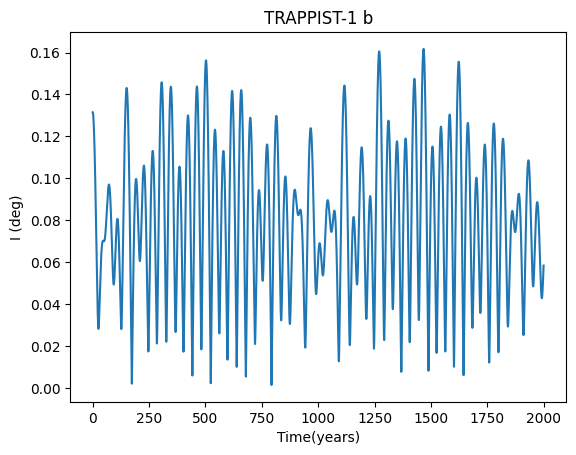

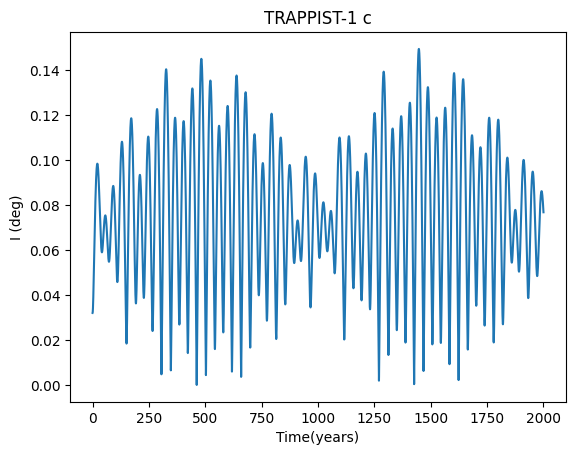

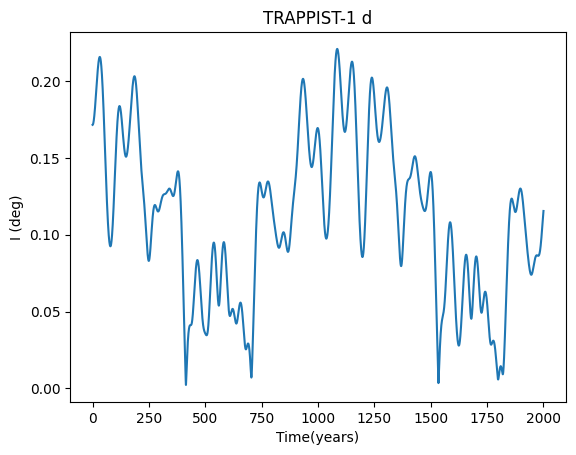

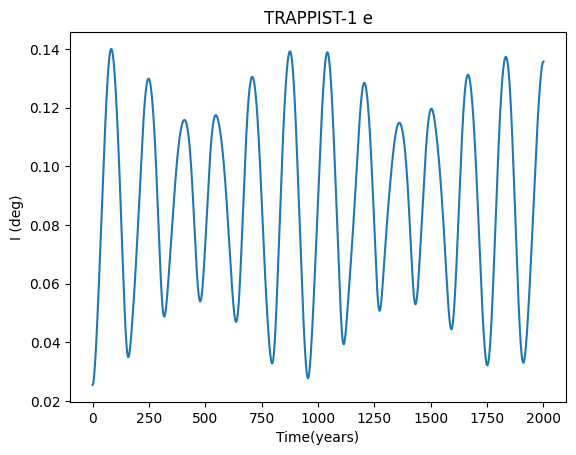

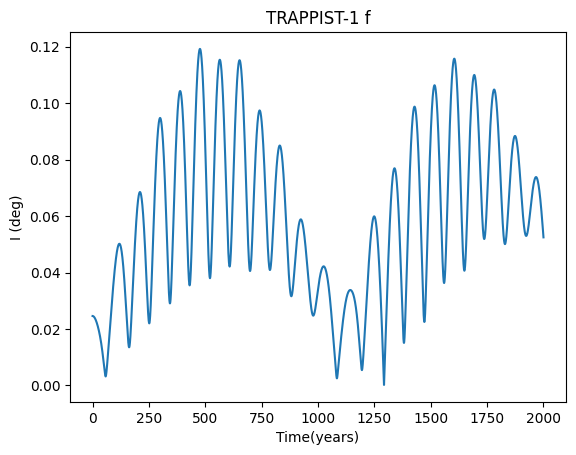

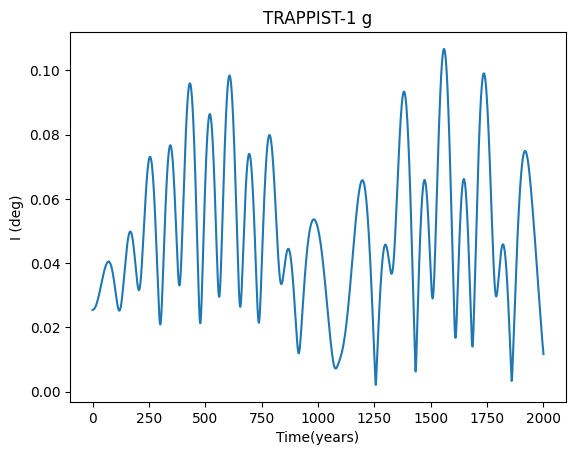

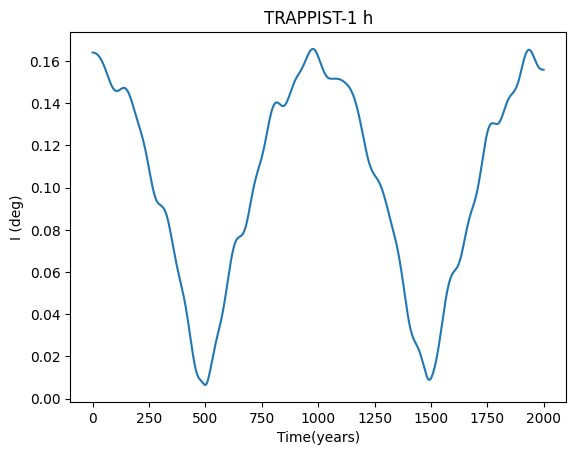

In [11]:
scaled_eigvecsB = 0.1*(pi/180) * eigvecs_B #rad

iterations = 10**5
timeline = np.linspace(0,2000,iterations)

p_time = np.zeros([number_of_planets,iterations])
q_time = np.zeros([number_of_planets,iterations])

for i in range(iterations):
    p_time[:,i] = np.matmul(scaled_eigvecsB,np.sin(eigvals_B*timeline[i]*(pi/180) ))
    q_time[:,i] = np.matmul(scaled_eigvecsB,np.cos(eigvals_B*timeline[i]*(pi/180) ))

I_time = np.sqrt(p_time**2 + q_time**2) #rad

for i in range(len(I_time)):
    plt.plot(timeline,I_time[i]*(180/pi))
    plt.xlabel('Time(years)')
    plt.ylabel('I (deg)')
    plt.title(Table1['Planet Name'][i])
    plt.show()

In [9]:
data = {
    'Name': ['TRAPPIST-1 b','TRAPPIST-1 c','TRAPPIST-1 d',
                    'TRAPPIST-1 e','TRAPPIST-1 f','TRAPPIST-1 g'
                    ,'TRAPPIST-1 h'] ,
    'Mode 1' : eigvecs_B[:,0],
    'Mode 2' : eigvecs_B[:,1],
    'Mode 3' : eigvecs_B[:,2],
    'Mode 4' : eigvecs_B[:,3],
    'Mode 5' : eigvecs_B[:,4],
    'Mode 6' : eigvecs_B[:,5],
    }
Table2 = pd.DataFrame(data=data)
data = {
    'Name' : ['Frequency(deg/yr)'],
    'Mode 1' : eigvals_B[0],
    'Mode 2' : eigvals_B[1],
    'Mode 3' : eigvals_B[2],
    'Mode 4' : eigvals_B[3],
    'Mode 5' : eigvals_B[4],
    'Mode 6' : eigvals_B[5],
}
Table3 = pd.DataFrame(data=data)

period = abs(360/eigvals_B)
data = {
    'Name' : ['Period(years)'],
    'Mode 1' : period[0],
    'Mode 2' : period[1],
    'Mode 3' : period[2],
    'Mode 4' : period[3],
    'Mode 5' : period[4],
    'Mode 6' : period[5],
}
Table4 = pd.DataFrame(data=data)
Table_dummy = pd.concat([Table2,Table3],ignore_index=True)
Table_eig = pd.concat([Table_dummy,Table4],ignore_index=True)

In [10]:
Table_eig.style.hide(axis='index')

Name,Mode 1,Mode 2,Mode 3,Mode 4,Mode 5,Mode 6
TRAPPIST-1 b,0.692316,0.124797,0.137134,0.207505,-0.250851,0.404387
TRAPPIST-1 c,-0.696612,0.033327,0.045064,0.141908,-0.229812,0.384207
TRAPPIST-1 d,0.188106,-0.835304,-0.831335,-0.402047,-0.087210,0.253375
TRAPPIST-1 e,0.006228,0.390618,0.007357,-0.834637,0.129479,0.045882
TRAPPIST-1 f,0.002488,-0.327513,0.464408,-0.029426,0.266064,-0.129964
TRAPPIST-1 g,0.000650,0.160117,-0.268218,0.273858,0.278644,-0.190602
TRAPPIST-1 h,0.000237,-0.009940,0.019377,-0.051766,-0.843479,-0.754541
Frequency(deg/yr),-9.935497,-5.105163,-4.788402,-2.843419,-0.974150,-0.611234
Period(years),36.233720,70.516844,75.181657,126.608145,369.552973,588.972146
